In [1]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
device = get_device()

'''
3-letter classification dataset (permuted without repetition)

in total, 6 classes

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'three_permuted_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
Initializing GPU cache for 2400 samples...
Cache initialized in 0.29 seconds
Initializing GPU cache for 600 samples...
Cache initialized in 0.03 seconds
num timesteps per sample: 48


In [2]:
num_h = 16

time_window = 48

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)


snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=16, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=16, out_features=16, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=16, out_features=6, bias=False)
    )
  )
)

In [3]:
ckpt_dir = 'permuted_3letters_task_H16WW'
num_epochs = 50

lr_tau = 0.1


train(snn_vf, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_f, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [6/18], Loss: 12.04675
Step [12/18], Loss: 10.54986
Step [18/18], Loss: 10.30908
Time elasped: 3.116743564605713
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 9.11204
Step [12/18], Loss: 7.93663
Step [18/18], Loss: 5.92778
Time elasped: 2.674212694168091
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 4.86941
Step [12/18], Loss: 4.40831
Step [18/18], Loss: 3.36591
Time elasped: 2.4470582008361816
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.66027
Step [12/18], Loss: 2.20807
Step [18/18], Loss: 2.09432
Time elasped: 2.7200913429260254
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.12755
Step [12/18], Loss: 1.99402
Step [18/18], Loss: 2.06545
Time elasped: 2.624972105026245
600
Test Loss: 1.9244446516036988
Avg spk_count per neuron for all 48 time-steps 45.68
Test Accuracy of the model on the test samples: 15.833

max acc: 15.833333333333334
Epoch [6/50], learning_rates 0.001000, 0.100000
Step [6/1

Text(0.5, 1.0, 'train loss')

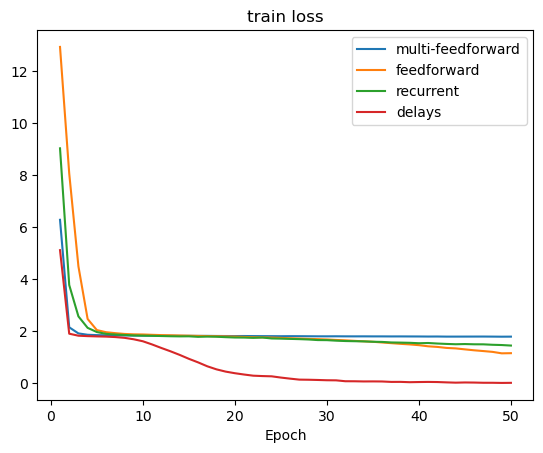

In [4]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

Text(0.5, 1.0, 'test loss')

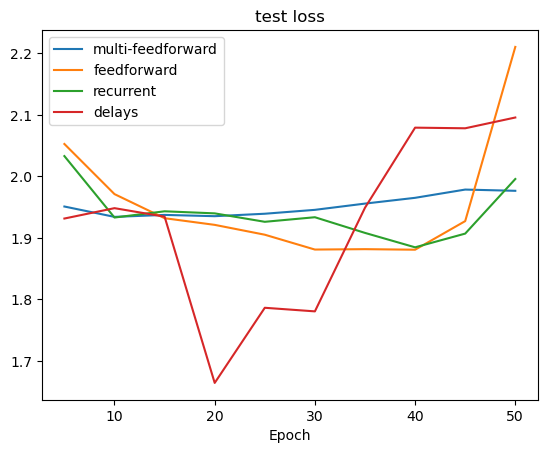

In [5]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.test_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.test_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.test_loss, label = 'recurrent')
plot_per_epoch(snn_rd.test_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('test loss')

In [6]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()


# from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
# images, labels_mf = propagate_batch_simple(snn_f, test_loader)
# _, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
# _, labels_rd = propagate_batch_simple(snn_rd, test_loader)

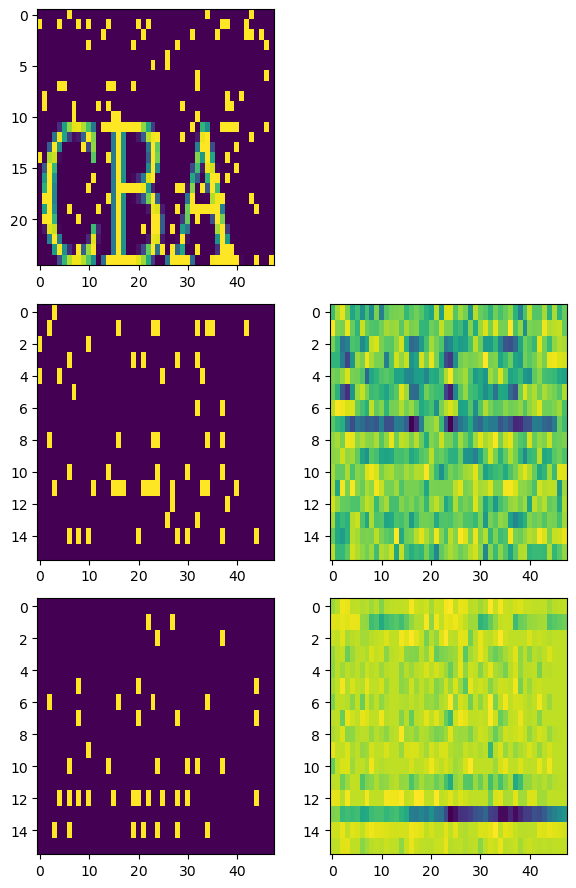

In [7]:
images, _ = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

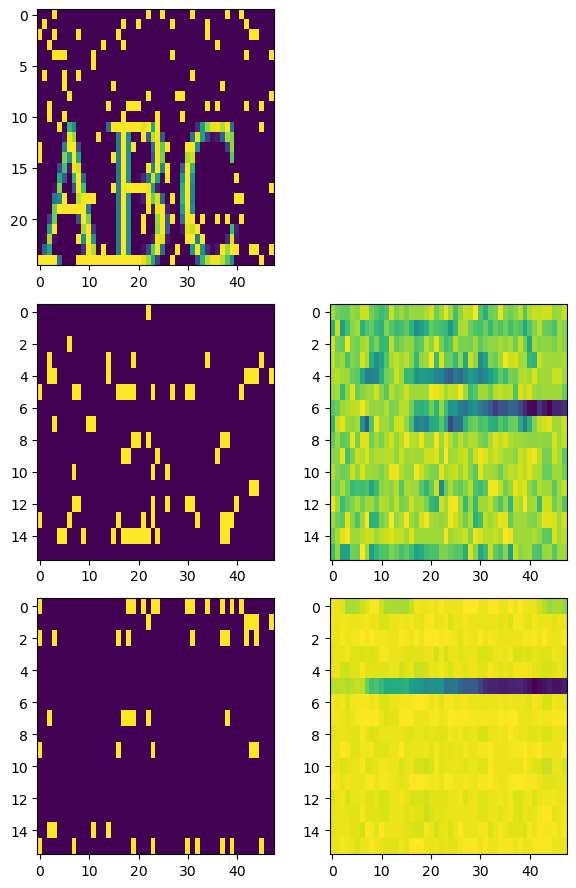

In [8]:
images, _ = propagate_batch_simple(snn_vf, test_loader)
spk = snn_vf.spike_state
mem = snn_vf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

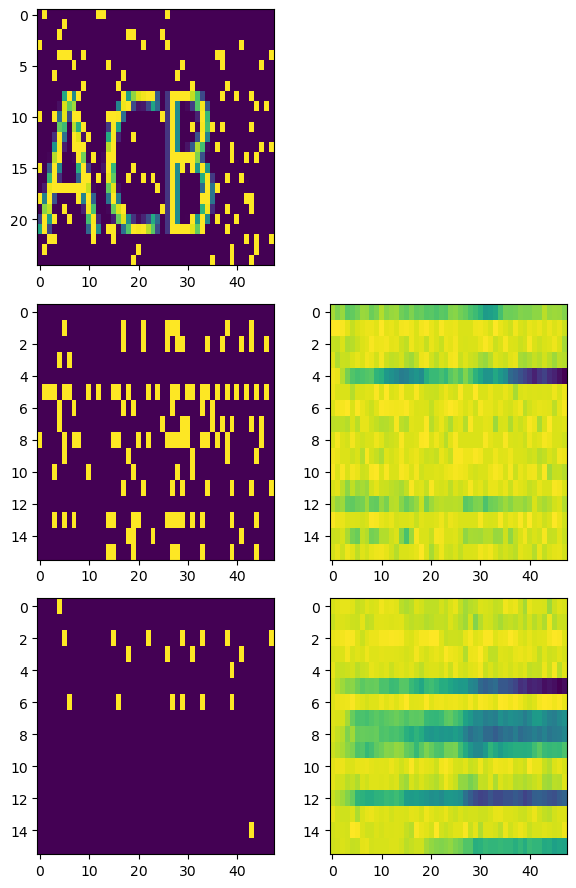

In [9]:
images, _ = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

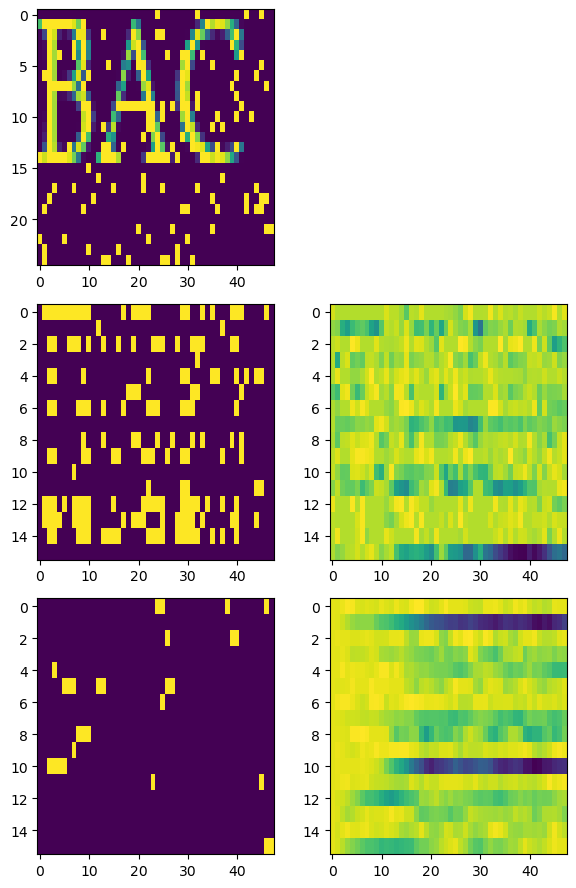

In [10]:
images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

In [11]:
ckpt_dir = 'permuted_3letters_task_H16WW'
snn_f.save_model('snn_mf', ckpt_dir)
snn_rnn.save_model('snn_rnn', ckpt_dir)
snn_rd.save_model('snn_rd', ckpt_dir)
snn_vf.save_model('snn_f', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16WW
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16WW
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16WW
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16WW


In [12]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'permuted_3letters_task_H16WW'
snn_vf = ModelLoader('snn_f', ckpt_dir, 128, 'cuda')
snn_mf = ModelLoader('snn_mf', ckpt_dir, 128, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 128, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 128, 'cuda')

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [13]:
a, b = snn_vf.test(test_loader)
a, b = snn_mf.test(test_loader)
a, b = snn_rnn.test(test_loader)
a, b = snn_rd.test(test_loader)

600
Test Loss: 2.071202540397644
Avg spk_count per neuron for all 48 time-steps 56.30083333333334
Test Accuracy of the model on the test samples: 31.167

600
Test Loss: 1.8504671096801757
Avg spk_count per neuron for all 48 time-steps 58.93833333333333
Test Accuracy of the model on the test samples: 18.167

600
Test Loss: 1.8735726594924926
Avg spk_count per neuron for all 48 time-steps 91.6075
Test Accuracy of the model on the test samples: 26.833

600
Test Loss: 1.9708399534225465
Avg spk_count per neuron for all 48 time-steps 87.38416666666667
Test Accuracy of the model on the test samples: 62.167

